In [4]:
execfile('../src/display_utils.py')
execfile('../src/moldev_utils.py')
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
summary = pd.read_csv('../output/condition_summary.csv')

In [6]:
colors = {'Blue & Red':'bwr','Blue':'Blues'}

---
# Well Plate Results

In [7]:
def get_params(df):
    cols = df.columns.tolist()
    return sorted([col for col in cols if col not in ['Well Name', 'Condition', 'Base', 'Dose', 'Unit', 'Drug','Function']])

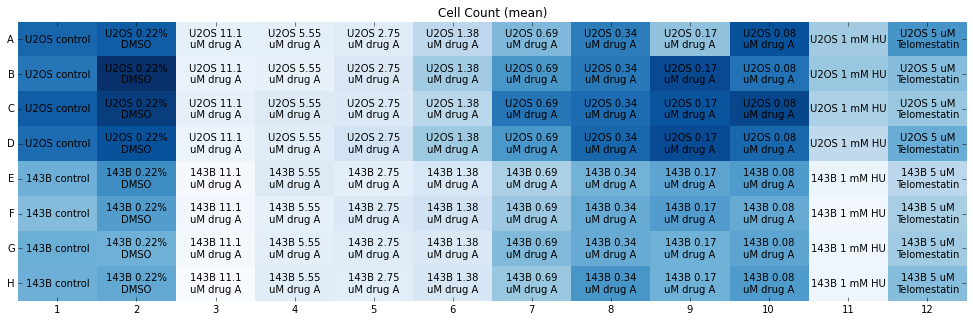

In [27]:
plate_data = add_condition_cols(pd.read_csv('../output/well_summary.csv'))
interact(plot_plate, 
         data = fixed(plate_data),
         parameter = widgets.Select(value = 'Cell Count',
                                    options= get_params(plate_data),
                                    height=250),
         function = plate_data['Function'].unique().tolist(),
         color = colors,
         show = widgets.ToggleButtons(options=['None','Values','Conditions']));

---
# How do conditions cluster together?

In [9]:
data = pipe(summary,
            get_means,
            lambda df: df.set_index('Condition'),
            normalize_columns)

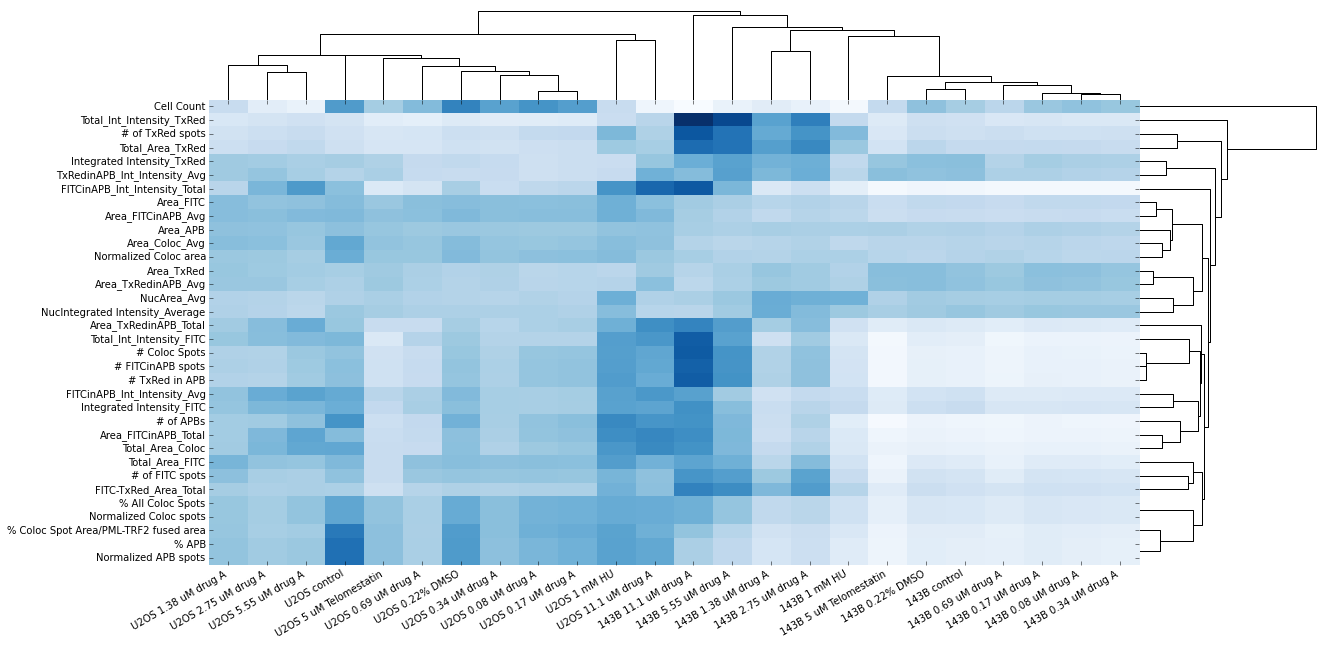

In [10]:
interact(matrix_tree, data = fixed(data), color = colors);

---
# Heatmap subsets

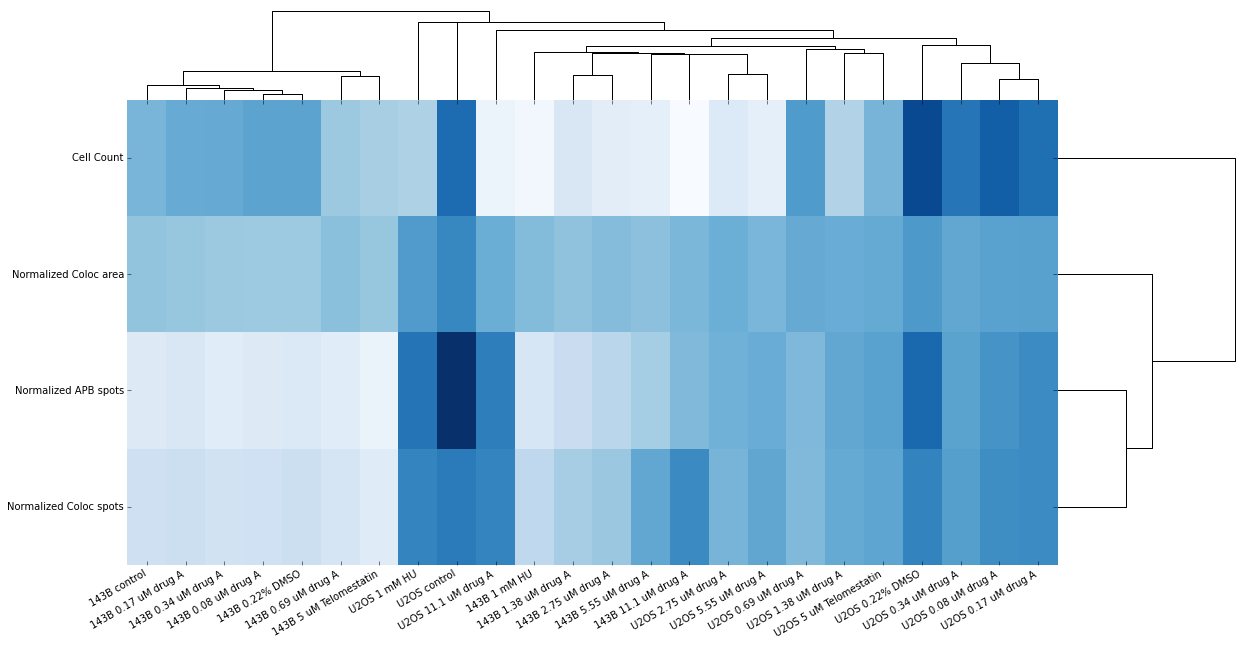

In [11]:
def wrapper(conditions,features,color):
    df = data.loc[list(conditions)][list(features)]
    try: 
        matrix_tree(df,color)
    except:
        print "\n".join(["-"*50, "Please select multiple features and conditions.","-"*50])

subset = interactive(wrapper,
                     conditions = widgets.SelectMultiple(options = data.index.values.tolist(),height = 300),
                     features = widgets.SelectMultiple(options = data.columns.values.tolist(),height = 300),
                     color = colors)
subset

---
# How do parameters vary with drug dose?

In [12]:
dose_data = thread_first(summary,
                        lambda df: df[df['Function'] == 'mean'],
                        add_condition_cols)

dose_error = thread_first(summary,
                        lambda df: df[df['Function'] == 'sem'],
                        add_condition_cols)

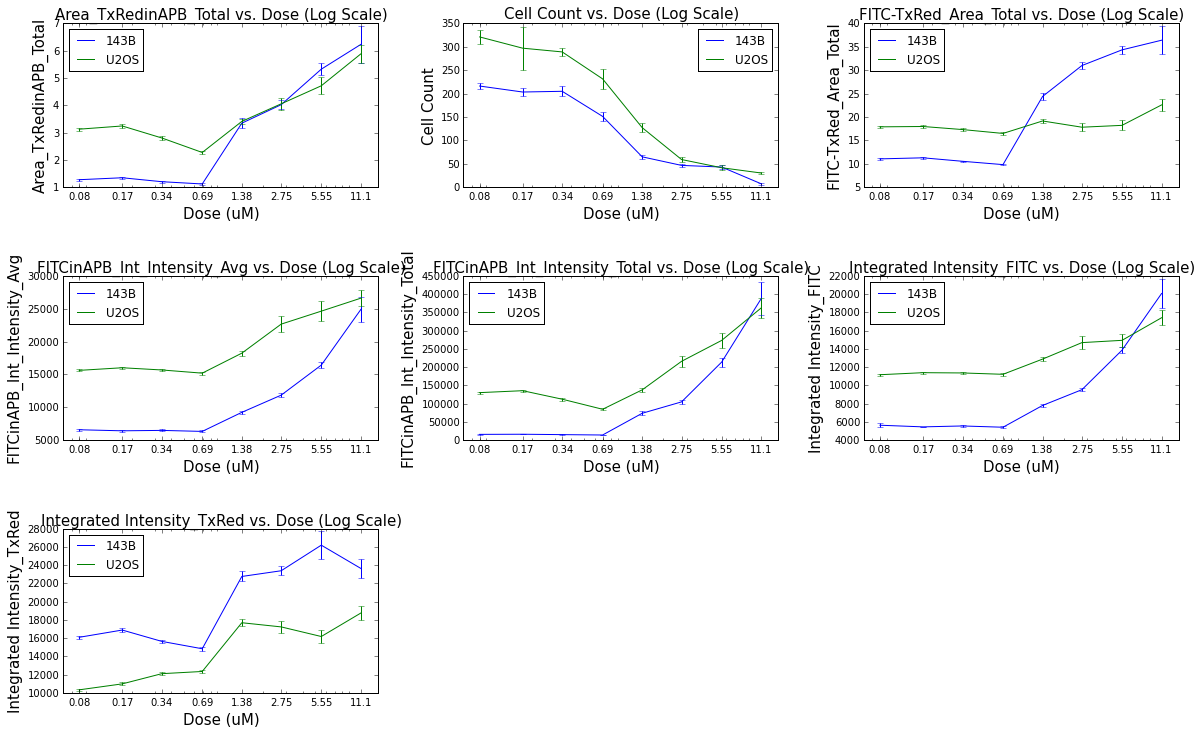

In [13]:
interact(dose_plot,
         scale = widgets.ToggleButtons(options=['linear','log']), 
         df = fixed(dose_data),
         err = fixed(dose_error),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= [col for col in dose_data.columns.values.tolist() if col not in ['Condition','Function','Base','Dose','Unit','Drug']],
                              height=250));

---
#How are different parameters related?

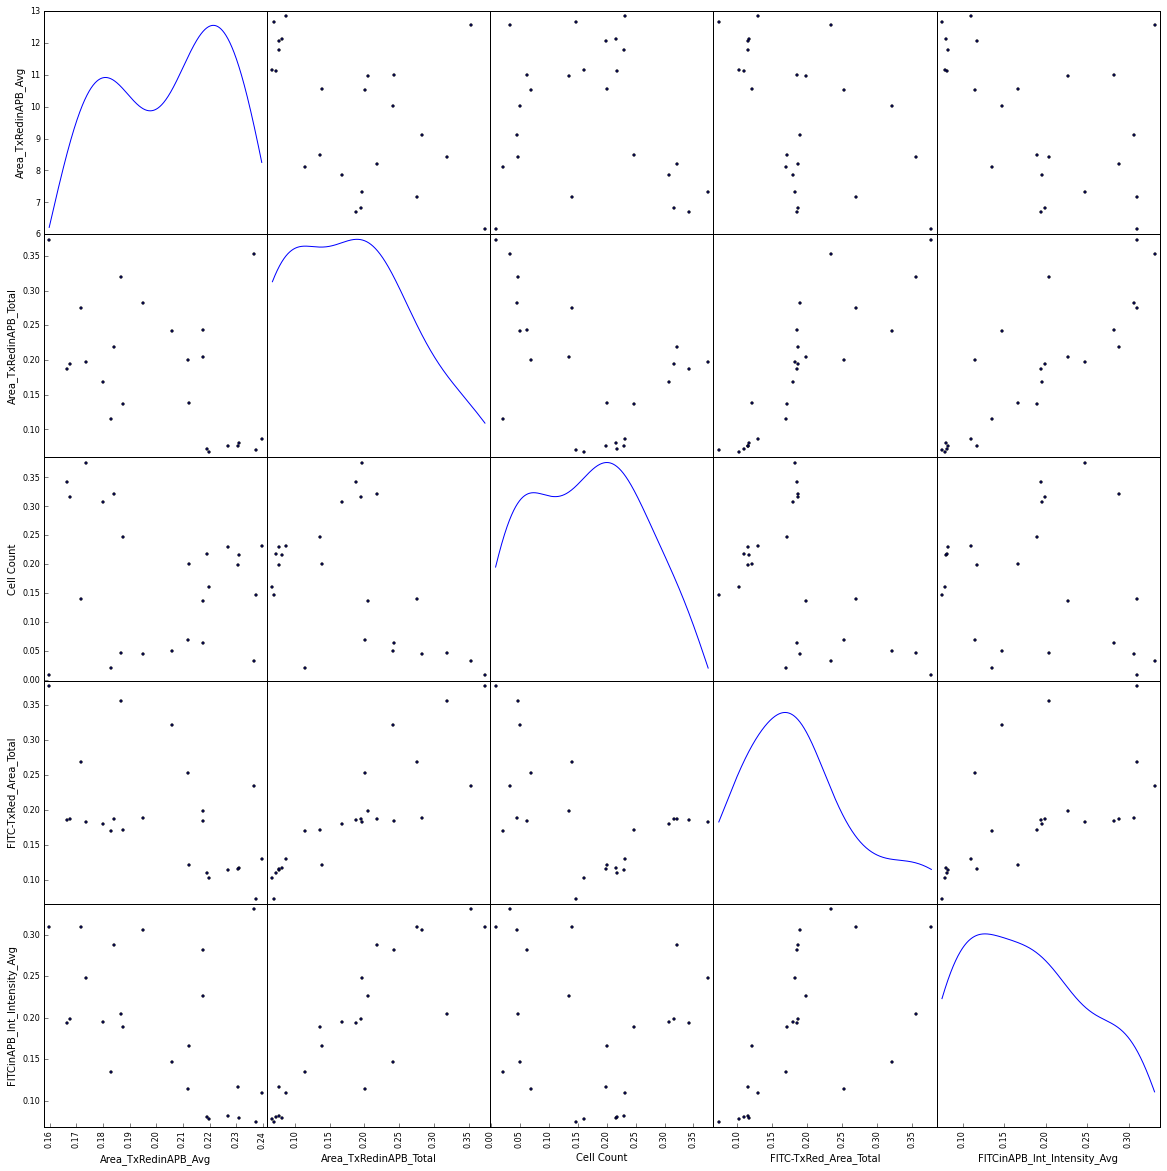

In [14]:
from pandas.tools.plotting import scatter_matrix

def scatter(df,cols):
    scatter_matrix(data[list(cols)], alpha=1, figsize=(20, 20), diagonal='kde');
    
interact(scatter, 
         df = fixed(filter_rows(dose_data,'Base','143B')),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= get_params(dose_data),
                              height=250));

---
# Parameter vs. Conditions

In [15]:
raw_cell_data = pd.read_csv('../output/moldev_cleaned.csv')
cell_data = add_condition_cols(raw_cell_data)

In [47]:
def plot_dist(df,base,parameter):
    if base == 'All':
        data = df.sort(['Base','Drug','Dose'])
    else: 
        data = df[df['Base'] == base].sort(['Drug','Dose'])
        
    fig = plt.figure(num=None, figsize=(15, 7), dpi=100, facecolor='w', edgecolor='k')
    sns.boxplot(data[parameter], 
                data['Condition'],
                vert=True,
                order=data.Condition.unique(),
                color = 'w')
    plt.ylabel(parameter,fontsize=20)
    plt.xlabel('Condition',fontsize=20)
    plt.title('Distribution: ' + parameter,fontsize=20)
    plt.tick_params(labelsize=20)
    plt.xticks(rotation=30,ha='right')
    mean = data[parameter].mean()
    plt.gca().set_ylim(bottom=data[parameter].mean() * -0.5)

In [48]:
def dist_wrapper(base,parameter):
    if parameter == 'Cell Count':
        df = filter_rows(plate_data,'Function','mean')
    else: 
        df = cell_data
    plot_dist(df,base,parameter)

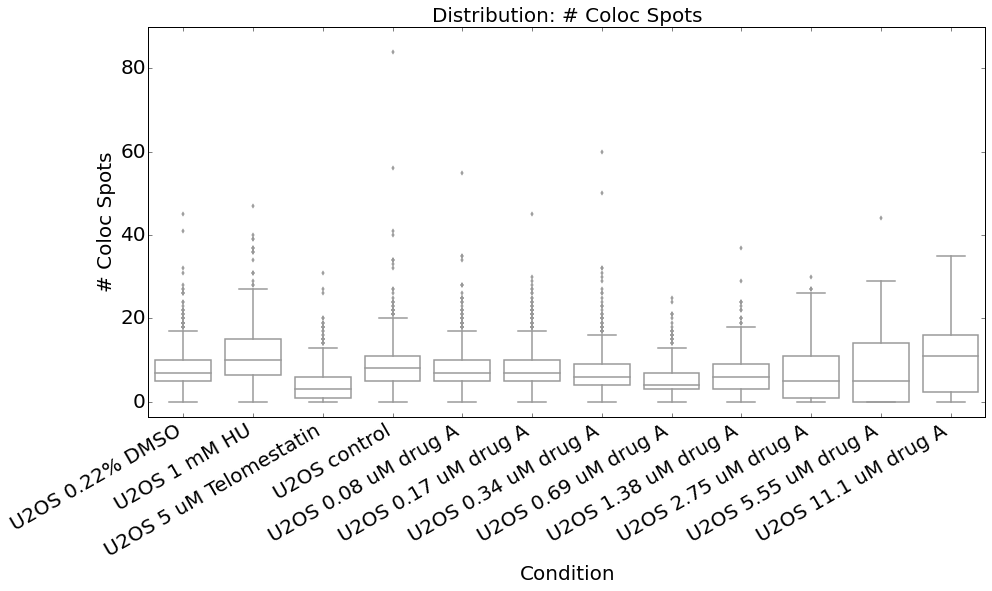

In [49]:
interactive(dist_wrapper,
            base = cell_data.Base.unique().tolist() + ['All'], 
            parameter = get_params(cell_data) + ['Cell Count'])

---
# Compare conditions

In [40]:
def compare_condition_dists(df, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(parameters)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for parameter,sub in zip(parameters,subs):
        plt.subplot(sub)
        param_bandwidth = bandwidth * df[df.Condition == conditions[0]][parameter].mean()
        for condition in conditions:
            data = df[df.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": param_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=condition)
            plt.legend(loc = 0)
        if scale is not 'linear':
            plt.xscale('log')
        plt.ylabel('Frequency')

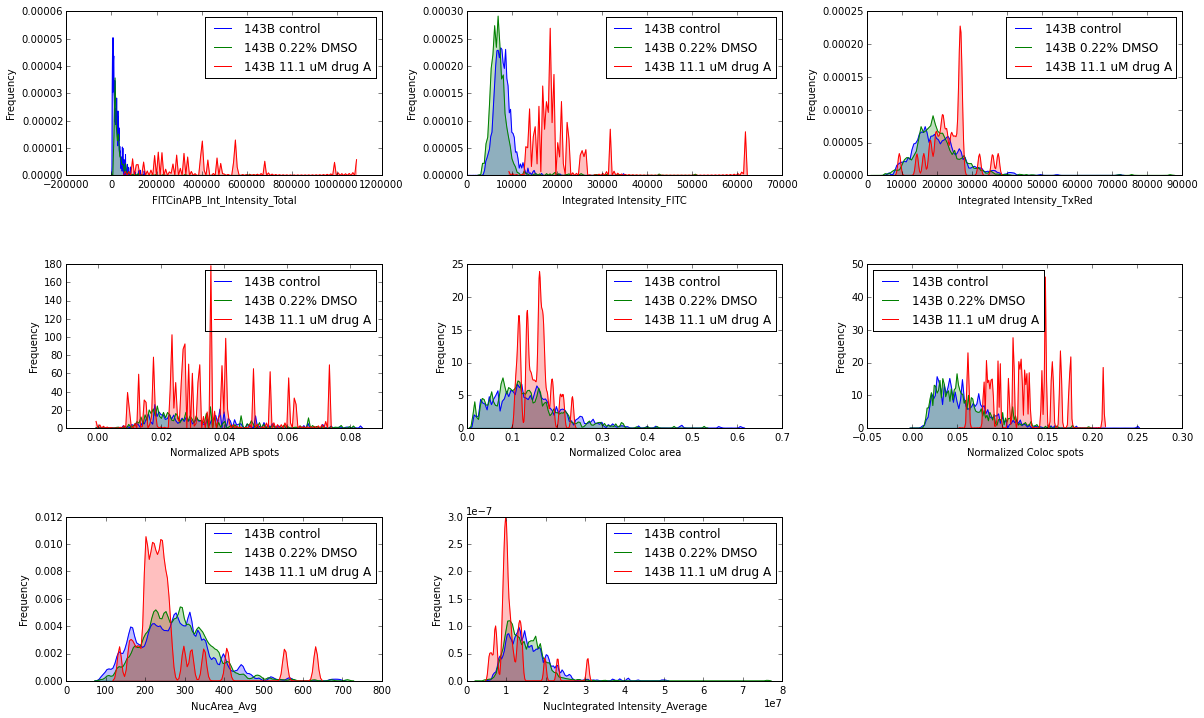

In [41]:
interact(compare_condition_dists,
         df = fixed(cell_data),
         conditions = widgets.SelectMultiple(options = cell_data.Condition.unique().tolist(),height = 300),
         parameters = widgets.SelectMultiple(options = get_params(cell_data),height = 300),
         bandwidth = (0,0.2,0.01),
         scale = widgets.ToggleButtons(options=['linear','log']));

---
# Compare parameters

In [42]:
def compare_parameter_dists(df, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(parameters)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for condition,sub in zip(conditions,subs):
        plt.subplot(sub)
        condition_bandwidth = bandwidth * df[df.Condition == condition][parameters[0]].mean()
        for parameter in parameters:
            data = df[df.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": condition_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=parameter)
            plt.legend(loc = 0)
        if scale is not 'linear':
            plt.xscale('log')
        plt.ylabel('Frequency')
        plt.xlabel(condition)

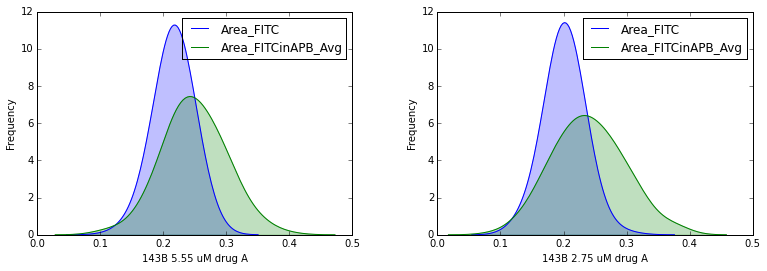

In [43]:
interact(compare_parameter_dists,
         df = fixed(cell_data),
         conditions = widgets.SelectMultiple(options = cell_data.Condition.unique().tolist(),height = 300),
         parameters = widgets.SelectMultiple(options = get_params(cell_data),height = 300),
         bandwidth = (0,0.2,0.01),
         scale = widgets.ToggleButtons(options=['linear','log']));